# Summary:

#### In this notebook, the optimal network configurations obtained from the runs in the preceding notebook ('03_Blue_in_Green.ipynb') is applied to different lenth of the (historical) training data set. The behavior of the learning curves with the length of the historical information taken into account to generate forecasts is investigated and an optimal length is inferred.

#### The experiements are run on the clean as well as distored datasets which were analyzed in the preceeding notebooks.

#### The inferred optimal range of historical information given the 7-day forecasting horizon is used as a guideline in the subsequent application, presented in the notebook '05_Flamenco_Sketches.ipynb'.

# Table of contents
* [1. Load modules](#Part1_link)
* [2. Clean time series](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Evaluate model performance under varying amounts of historical information](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Visualize and save results](#Part2.2_link)
* [3. Distorted time series](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Evaluate model performance under varying amounts of historical information](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Visualize and save results](#Part3.2_link)

<a id='Part1_link'></a>
# 1. Load modules

In [3]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Clean time series

Evaluate model performance for a range of historical training data lengths. 

In [5]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# set target feature 
mdq._selected_features = ['observations']

# initialize dataframe to store time series
df = pd.DataFrame(data={'observations': observations})
df.index = idx

# load dataframe into object
mdq.df = df

# initialize dataset from dataframe 
mdq.initialize_dataset()

# standardize data
mdq.standardize_data()

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)

# specify model configuration: this is chosen basen on the results from the previous notebook 02_Freddie_Freeloader.ipynb
units = 128  # number of units in each neural network layer
num_layers = 2  # total number of layers
epochs = 50


<a id='Part2.1_link'></a>
### 2.1 Evaluate model performance under varying amounts of historical information

The following steps are repeated from the previous notebook, '02_Freddie_Freeloader.ipynb', and are grouped into one single step here for simplicity.

In [ ]:
# choose a few past history sizes
past_history_sizes = [1 * future_target_size, 10 * future_target_size, 20 * future_target_size, 52 * future_target_size]

# initialize results dictionary
res_2 = {'model_type': [], 'past_history_size': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:
    
    for past_history_size in past_history_sizes:
        
        # generate train and validation data
        mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

        # set number of steps per epoch
        num_samples = mdq._num_samples
        steps_per_epoch = int(num_samples/future_target_size)
        validation_steps = int(steps_per_epoch/2)

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)

        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]

        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)

        # append results to results dictionary
        res_2['model_type'].append(model_type)
        res_2['past_history_size'].append(past_history_size)
        res_2['val_mse'].append(val_mse)
        res_2['mse'].append(mse)
        res_2['total_training_time'].append(total_training_time)

training set shape: x:(1267, 7, 1), y:(1267, 7, 1)
validation set shape: x:(532, 7, 1), y:(532, 7, 1)
Epoch 1/50
181/181 [==============================] - 1s 4ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/50
181/181 [==============================] - 1s 3ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 3/50
181/181 [==============================] - 1s 3ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/50
181/181 [==============================] - 1s 4ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 5/50
181/181 [==============================] - 1s 3ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 6/50
181/181 [==============================] - 1s 3ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/50
181/181 [==============================] - 1s 3ms/step - loss: 0.0123 - mse: 0.0123 - val_loss:

172/172 [==============================] - 2s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 11/50
172/172 [==============================] - 3s 15ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 9.8064e-04 - val_mse: 9.8064e-04
Epoch 12/50
172/172 [==============================] - 2s 14ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 13/50
172/172 [==============================] - 2s 14ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 7.6277e-04 - val_mse: 7.6277e-04
Epoch 14/50
172/172 [==============================] - 2s 13ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 15/50
172/172 [==============================] - 2s 14ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 16/50
172/172 [==============================] - 2s 14ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 17/50
172/172 [==============================] - 2s 

162/162 [==============================] - 4s 26ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 21/50
162/162 [==============================] - 4s 25ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 22/50
162/162 [==============================] - 4s 27ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 23/50
162/162 [==============================] - 4s 26ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 24/50
162/162 [==============================] - 4s 26ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 25/50
162/162 [==============================] - 5s 28ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 26/50
162/162 [==============================] - 5s 28ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 27/50
162/162 [==============================] - 4s 27ms/step - loss

130/130 [==============================] - 9s 69ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 31/50
130/130 [==============================] - 9s 69ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 32/50
130/130 [==============================] - 10s 74ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 33/50
130/130 [==============================] - 9s 71ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 34/50
130/130 [==============================] - 9s 68ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 35/50
130/130 [==============================] - 9s 72ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 36/50
130/130 [==============================] - 9s 70ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 37/50
130/130 [==============================] - 9s 68ms/step - los

181/181 [==============================] - 1s 8ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 41/50
181/181 [==============================] - 1s 8ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 42/50
181/181 [==============================] - 1s 8ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 43/50
181/181 [==============================] - 1s 8ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 44/50
181/181 [==============================] - 1s 8ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 7.4343e-04 - val_mse: 7.4343e-04
Epoch 45/50
181/181 [==============================] - 2s 8ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 3.8796e-04 - val_mse: 3.8796e-04
Epoch 46/50
181/181 [==============================] - 1s 8ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 47/50
181/181 [==============================] - 1s 8ms/ste

<a id='Part2.2_link'></a>
### 2.2 Visualize and save results

In [ ]:
# transform dictionary to dataframe
df_res_22 = pd.DataFrame(res_2)

# store dataframe as csv locally
df_res_22.to_csv('../data/04_results_cleanData.csv')

In [ ]:
# visualize results
# compare RNN to LSTM results

df_res = df_res_22

x_label = 'past_history_size'
y_label = 'mse'
z_label = 'val_mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    
    plt.scatter(x, y, alpha=0.6, c="red", linewidth=0.0, label='training')
    plt.scatter(x, z, alpha=0.6, c="blue", linewidth=0.0, label='validation')
        
    plt.xlabel('past history data size [days]')
    plt.ylabel('mse')
    plt.legend()
    plt.title('clean dataset: {} model'.format(model_type))
    plt.show()

<a id='Part3_link'></a>
# 3. Distorted time series

Run RNN and LSTM model with noise added ontop of the clean data. Evaluate model performance for a range of variances of the noise.

<a id='Part3.1_link'></a>
### 3.1 Evaluate model performance under varying noise levels

training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)
Epoch 1/50
129/129 [==============================] - 10s 76ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/50
129/129 [==============================] - 9s 68ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3/50
129/129 [==============================] - 9s 69ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 4/50
129/129 [==============================] - 9s 68ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 5/50
129/129 [==============================] - 9s 67ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 6/50
129/129 [==============================] - 9s 67ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 7/50
129/129 [==============================] - 9s 68ms/step - loss: 0.0494 - mse: 0.0494 -

129/129 [==============================] - 8s 65ms/step - loss: 0.9996 - mse: 0.9996 - val_loss: 0.9812 - val_mse: 0.9812
Epoch 21/50
129/129 [==============================] - 8s 65ms/step - loss: 1.0000 - mse: 1.0000 - val_loss: 0.9795 - val_mse: 0.9795
Epoch 22/50
129/129 [==============================] - 8s 65ms/step - loss: 1.0150 - mse: 1.0150 - val_loss: 0.9816 - val_mse: 0.9816
Epoch 23/50
129/129 [==============================] - 8s 66ms/step - loss: 1.0042 - mse: 1.0042 - val_loss: 0.9884 - val_mse: 0.9884
Epoch 24/50
129/129 [==============================] - 8s 63ms/step - loss: 1.0169 - mse: 1.0169 - val_loss: 0.9873 - val_mse: 0.9873
Epoch 25/50
129/129 [==============================] - 8s 65ms/step - loss: 0.9964 - mse: 0.9964 - val_loss: 0.9788 - val_mse: 0.9788
Epoch 26/50
129/129 [==============================] - 8s 65ms/step - loss: 1.0149 - mse: 1.0149 - val_loss: 0.9817 - val_mse: 0.9817
Epoch 27/50
129/129 [==============================] - 8s 64ms/step - loss

129/129 [==============================] - 39s 299ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 31/50
129/129 [==============================] - 39s 304ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 32/50
129/129 [==============================] - 48s 370ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 33/50
129/129 [==============================] - 54s 421ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 34/50
129/129 [==============================] - 55s 424ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 35/50
129/129 [==============================] - 56s 436ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 36/50
129/129 [==============================] - 57s 439ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 37/50
129/129 [==============================] - 58s 4

129/129 [==============================] - 57s 443ms/step - loss: 0.9744 - mse: 0.9744 - val_loss: 1.1345 - val_mse: 1.1345
Epoch 49/50
129/129 [==============================] - 56s 433ms/step - loss: 0.9986 - mse: 0.9986 - val_loss: 1.1348 - val_mse: 1.1348
Epoch 50/50
129/129 [==============================] - 64s 493ms/step - loss: 0.9708 - mse: 0.9708 - val_loss: 1.1344 - val_mse: 1.1344


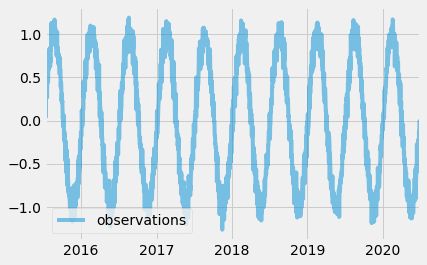

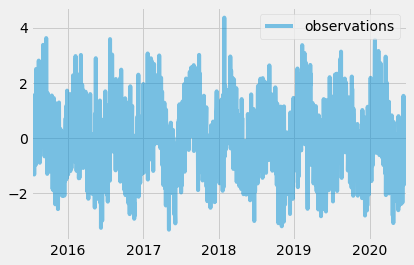

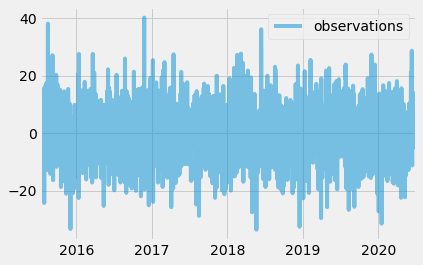

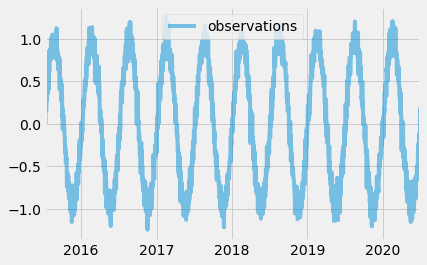

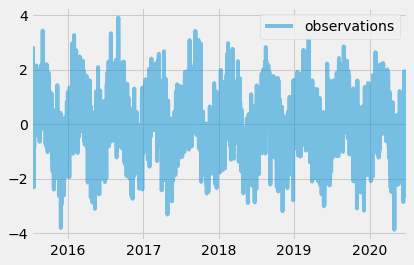

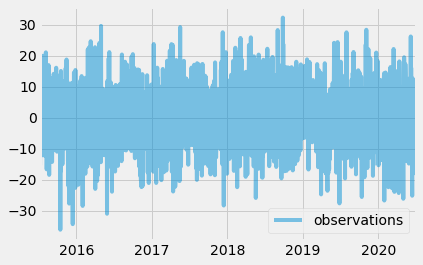

In [15]:
# initialize results dictionary
res_3 = {'model_type': [], 'std': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:
    
    for past_history_size in past_history_sizes:
        
        # generate train and validation data
        mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

        # set number of steps per epoch
        num_samples = mdq._num_samples
        steps_per_epoch = int(num_samples/future_target_size)
        validation_steps = int(steps_per_epoch/2)

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)

        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]

        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)

        # append results to results dictionary
        res_2['model_type'].append(model_type)
        res_2['past_history_size'].append(past_history_size)
        res_2['val_mse'].append(val_mse)
        res_2['mse'].append(mse)
        res_2['total_training_time'].append(total_training_time)

<a id='Part3.2_link'></a>
### 3.2 Visualize and save results

In [16]:
# transform dictionary to dataframe
df_res_32 = pd.DataFrame(res_3)

# store dataframe as csv locally
df_res_32.to_csv('../data/04_results_distored.csv')

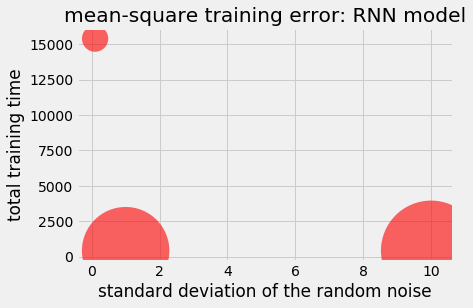

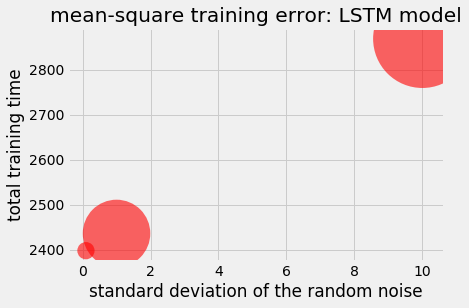

In [17]:
# visualize results
# compare RNN to LSTM results

df_res = df_res_32

x_label = 'past_history_size'
y_label = 'mse'
z_label = 'val_mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    
    plt.scatter(x, y, alpha=0.6, c="red", linewidth=0.0, label='training')
    plt.scatter(x, z, alpha=0.6, c="blue", linewidth=0.0, label='validation')
        
    plt.xlabel('past history data size [days]')
    plt.ylabel('mse')
    plt.title('noisy dataset: {} model'.format(model_type))
    plt.show()